In [1]:
from collections import defaultdict
import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
input_shape = (224, 224, 3)
num_clusters = 4
path_to_images = './width0.5_cleaned'
path_to_clusters = './img_cluster_4'

# Function to create directories for clusters
def create_cluster_dirs(num_clusters, base_path=path_to_clusters):
    for i in range(num_clusters):
        os.makedirs(os.path.join(base_path, f'cluster_{i}'), exist_ok=True)

# Read in data and labels (if available)
data, labels = [], []
for subdir, dirs, files in os.walk(path_to_images):
    for file in files:
        img_path = os.path.join(subdir, file)
        im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        im = cv2.resize(im, input_shape[:2])
        im = np.stack((im,) * 3, axis=-1)  # Stack grayscale image across 3 channels to maintain the input shape
        data.append(im)
        # If you have labels for supervised learning, load them here
        # labels.append(load_label_for_image(img_path))

data = np.array(data, dtype='float32') / 255.0

# Data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="reflect"),
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.2, fill_mode="reflect"),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="reflect"),
    # Since we are ignoring color, no color augmentations are used
])

# Using a pre-trained model as a feature extractor
pretrained_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
pretrained_model.trainable = False

# Feature extraction with pretrained model
features = pretrained_model.predict(data_augmentation(data), batch_size=4, verbose=1)
# Clustering with KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(features)

# Store clustered images
create_cluster_dirs(num_clusters)
for i, cluster_id in enumerate(cluster_ids):
    img = (data[i] * 255).astype('uint8')
    img_path = os.path.join(path_to_clusters, f'cluster_{cluster_id}', f'img_{i}.png')
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


15/15 [==============================] - 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1/1 [==============================] - 0s 187ms/step


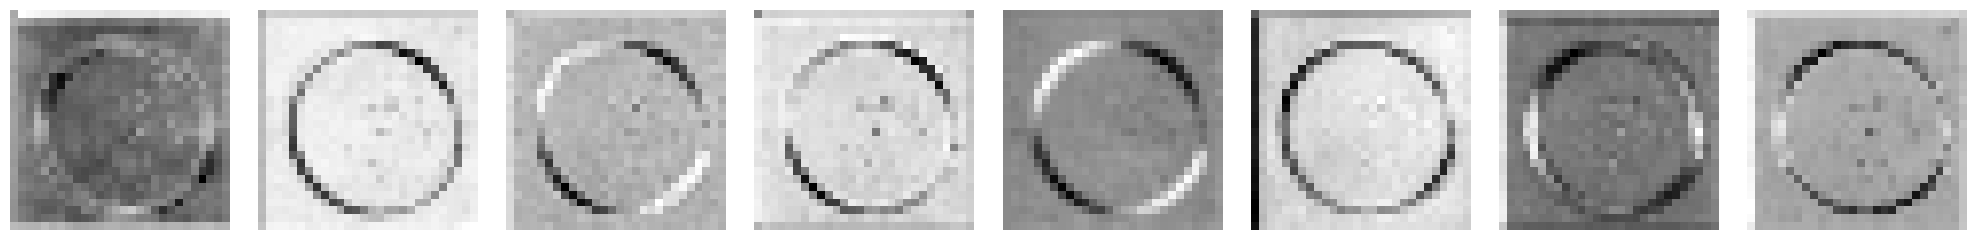

In [7]:
# Select an earlier layer of the model
layer_name = 'conv2_block3_out'  # This is an earlier layer in ResNet50V2
intermediate_layer_model = keras.Model(inputs=pretrained_model.input,
                                       outputs=pretrained_model.get_layer(layer_name).output)

# Get the output from this layer for a specific image
intermediate_output = intermediate_layer_model.predict(np.expand_dims(data[0], axis=0))

# Normalization function to scale the activation values
def normalize_activation(activations):
    normalized_activations = (activations - activations.min()) / (activations.max() - activations.min())
    return normalized_activations

# Display the normalized feature maps
num_feature_maps_to_display = 8  # You can adjust this number
feature_maps_indices = np.linspace(0, intermediate_output.shape[-1] - 1, num_feature_maps_to_display, dtype=int)
fig, axes = plt.subplots(1, num_feature_maps_to_display, figsize=(20, 2.5))
for i, ax in enumerate(axes.flat):
    feature_map_index = feature_maps_indices[i]
    feature_map = normalize_activation(intermediate_output[0, :, :, feature_map_index])
    ax.imshow(feature_map, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [10]:
# Assuming 'data' is your preprocessed dataset and 'pretrained_model' is your model.

def plot_feature_maps(model, data, layer_name, num_images=5, num_feature_maps=8):
    """
    Plots the feature maps for a specified number of images and feature maps.

    Parameters:
    - model: The pretrained model.
    - data: The dataset to use for visualization.
    - layer_name: The name of the layer from which to extract the feature maps.
    - num_images: The number of images to visualize.
    - num_feature_maps: The number of feature maps to visualize per image.
    """
    # Create a model that outputs feature maps from the specified layer
    intermediate_layer_model = keras.Model(inputs=model.input,
                                           outputs=model.get_layer(layer_name).output)

    # Select a subset of images
    selected_images = data[:num_images]

    # Iterate over selected images
    for img_index, img in enumerate(selected_images):
        # Get the output from this layer for a specific image
        intermediate_output = intermediate_layer_model.predict(np.expand_dims(img, axis=0))

        # Plotting
        fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 2.5))
        plt.suptitle(f'Feature maps for image {img_index}')

        # Select feature maps indices to display
        feature_maps_indices = np.linspace(0, intermediate_output.shape[-1] - 1, num_feature_maps, dtype=int)

        # Normalize and display each feature map
        for i, ax in enumerate(axes.flat):
            feature_map_index = feature_maps_indices[i]
            feature_map = intermediate_output[0, :, :, feature_map_index]
            feature_map_normalized = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            ax.imshow(feature_map_normalized, cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Call the function to plot feature maps
plot_feature_maps(pretrained_model, data, 'conv2_block3_out', num_images=59, num_feature_maps=8)


Output hidden; open in https://colab.research.google.com to view.